In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [3]:
# Download data for a specific stock
stock_data = yf.download("AAPL", start="2010-01-01", end="2024-01-01")

# Use only the 'Close' column for prediction
stock_prices = stock_data['Close'].values
stock_prices = stock_prices.reshape(-1, 1)


[*********************100%***********************]  1 of 1 completed


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_prices)


In [5]:
# Define the window size
look_back = 60

# Prepare the training data
X_train, y_train = [], []
for i in range(look_back, len(scaled_data) - 15):  # Exclude the last 15 days
    X_train.append(scaled_data[i - look_back:i, 0])  # Last 60 days
    y_train.append(scaled_data[i:i + 15, 0])        # Next 15 days

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Reshape for RNN


In [20]:
# Initialize the RNN
model = Sequential()

# Add an Input layer
model.add(Input(shape=(X_train.shape[1], 1)))

# Add LSTM layers
model.add(LSTM(units=50, activation='tanh', return_sequences=True))  # Output shape: (batch_size, timesteps, 50)
model.add(LSTM(units=50, activation='sigmoid', return_sequences=True))  # Pass the full sequence
model.add(LSTM(units=50, activation='relu', return_sequences=False))  # Output shape: (batch_size, 50)

# Add Dense layers
model.add(Dense(units=25, activation='relu'))  # Adding activation to Dense layer
model.add(Dense(units=15))  # Predict 15 future prices

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [21]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.2728
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0329
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0113
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0078
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0073
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0070
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0064
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0058
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0054
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0057
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0065
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0049
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0047
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0053
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0055
Epoc

In [22]:
# Use the last 60 days of the training data for prediction
last_60_days = scaled_data[-look_back:]
X_test = last_60_days.reshape(1, look_back, 1)

# Predict the next 15 days
predicted_prices = model.predict(X_test)

# Reverse the normalization
predicted_prices = scaler.inverse_transform(predicted_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


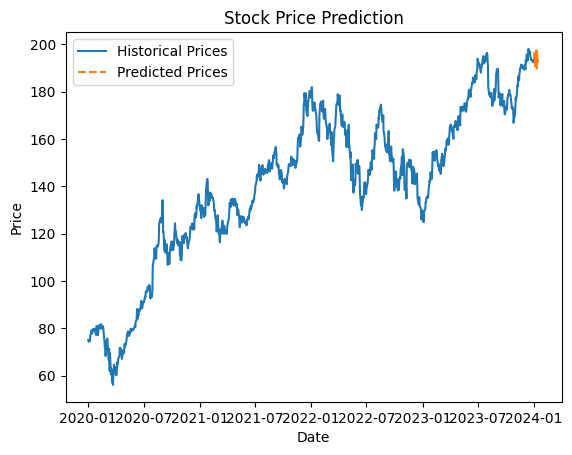

In [23]:
# Visualize the predictions
future_days = pd.date_range(start=stock_data.index[-1], periods=15, freq='B')  # 15 business days
plt.plot(stock_data['Close'], label="Historical Prices")
plt.plot(future_days, predicted_prices.flatten(), label="Predicted Prices", linestyle='--')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()
